# Ceilometer Data Processing (L1)
L1 Contains
 - Standardized File (5760, 1024)
 - RCS 10 min average
 - CBL 30 min 
 - Precipitaiton Mask
 - Readable Timestamp & np.datetime64
 
 
 **designed to work ONLY on CHM15k Nimbus. The functions will check...**

---
#### Importing Packages
---

In [1]:
# ploting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import matplotlib.units as munits

# data processing
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import xarray as xr
import pandas as pd

# utilities
from datetime import datetime
from pathlib import Path
from numba import jit
import numpy as np
from copy import deepcopy

---
#### Function Space
---

**Importing Data**

In [2]:
def importing(FilePaths, standard_time=True, **kwargs):

    # if "variables" in kwargs.keys():
    #     variables=kwargs["variables"]
    # else:
    #     variables=["beta_raw", "pbl", ""]

    data = {} # creating a dictionary to hold all the data imported
    filePaths = [Path(filePath) for filePath in FilePaths] # converting to Pathlib objects

    # Using a loop to import each file from FilePaths
    for filePath in filePaths:

        # Validating supplied path
        if filePath.is_file() is False:
            print('PATH IS NOT FOUND ON MACHINE')
            return

        # Creating a nested dictionary
        data[filePath.name] = {}

        # Using Xarrays to import each NetCDF4 file
        with xr.open_dataset(filePath) as file:
            if file.title != "CHM15k Nimbus":
                print("This module is only apporved for use with CHM15k Nimbus datasets")
                return

            data[filePath.name]["dataset"] =  file # This contains EVERYTHING inside the file
            data[filePath.name]["lat_lon_elevation"] = [file.longitude.values, file.latitude.values, file.altitude.values]

            if standard_time == True:
                data[filePath.name]["RCS"] = file.beta_raw.resample(time="15s").mean()
            else:
                data[filePath.name]["RCS"] = file.beta_raw

    return data, list(data.keys())

**Precipitation Filter**

In [3]:
def filter_precip(dataArray, precip_signal_threshold = 4e5):
    
    # Define number of times to loop
    ntimes = dataArray.time.shape[0]

    # Initialize precip flag array
    precip = np.zeros(ntimes)
    precip[:] = np.nan

    # Define index of 200m for top boundary of precip
    index_200m = np.where(dataArray.range<=200)[0][-1]+1
    # print(index_200m)

    # Loop all times to find precip
    for t in np.arange(ntimes):

        # Label signal to 1/0 if over/under threshold defined
        uL = dataArray.T.values
        precip_flag = uL[:index_200m,t] >= precip_signal_threshold

        # Find sum of column observations under 200m under threshold
        false_flags = sum(precip_flag==False)

        if false_flags==0:  # If no observations fall under threshold, mark as precip (1)
            precip[t]=1
        elif false_flags>=1: # If any observations fall over threshold, mark as (0)
            precip[t]=0

    # Change to integer array
    precip = precip.astype(int)

    # Add precip flag to data dictionary
    pflags = pd.DataFrame({"datetime": dataArray.time, "flag": precip})

    return pflags

**Haar Wavelet**

In [4]:
@jit(nopython=True)
def haar(length,a,b):

    # Zero Array to fill in Wavelet
    wavelet = np.zeros(length)
    
    # Haar Wavelet (see eqn 1 screenshot)
    wavelet[np.int64(b - a):np.int64(b)] = -1
    wavelet[np.int64(b):np.int64(b + a)] = 1
    wavelet[b] = 0

    return wavelet

**Covariance Profile**

In [5]:
@jit(nopython=True)
def covariance_profile(profile,a,alts):

    # Initialize covariance array
    w = np.zeros(alts.shape[0])
    wavelets = np.zeros((alts.shape[0], alts.shape[0]))
    
    # Height boundaries for wavelet
    z_top = np.int64(a)+1
    z_bot = profile.shape[0]-np.int64(a)-1

    # Calculate covariance coefficients and fill covariance array for each altitude
    f = profile
    for z in np.arange(0, len(alts)):
        wavelets[z] = haar(len(alts), a, z)
        w[z] = np.nansum(f * wavelets[z]) / a

    return w, f, wavelets

In [6]:
def coef_avg(prof, a_vals):
    c_avg = np.zeros(prof.shape)
    for i in np.arange(prof.shape[0]):
        c = np.zeros((prof.shape[1], len(a_vals)))
        
        for a, j in zip(a_vals, np.arange(0, c.shape[1])):
            cwt, f, wavelets = covariance_profile(prof[i, :], a, alts)
            c[:, j] = cwt

        c_avg[i, :] = np.mean(c, axis=1)
    return c_avg

---
#### Work Space
---

**Importing File**

**I begin by** importing the data file and visually inspecting the elements.

In [7]:
FilePaths = ['C:/Users/Magnolia/OneDrive - UMBC/Research/Analysis/Process/TRACER-AQ/ceilometer/20210802/20210802_TROPOZ_CHM200123_000.nc']
Data, keys = importing(FilePaths)
print(Data)

{'20210802_TROPOZ_CHM200123_000.nc': {'dataset': <xarray.Dataset>
Dimensions:         (time: 5760, range: 1024, range_hr: 32, layer: 3)
Coordinates:
  * time            (time) datetime64[ns] 2021-08-02T00:00:06 ... 2021-08-02T...
  * range           (range) float32 14.98 29.97 44.96 ... 1.533e+04 1.534e+04
  * range_hr        (range_hr) float32 0.001 4.995 9.99 ... 144.9 149.9 154.8
  * layer           (layer) int32 1 2 3
Data variables: (12/41)
    latitude        float32 3.9e-05
    longitude       float32 -7.6e-05
    azimuth         float32 ...
    zenith          float32 ...
    altitude        float32 0.0
    wavelength      float32 ...
    ...              ...
    cdp             (time, layer) int16 ...
    cde             (time, layer) int16 ...
    cho             int16 ...
    nn1             (time) int16 ...
    nn2             (time) int16 ...
    nn3             (time) int16 ...
Attributes: (12/15)
    title:             CHM15k Nimbus
    source:            CHM200123
    d

**After inspection,** I create three new variables; 10 min averaged RCS (*RCS_10min*), a precipitation mask (*precip_mask*), and standardized RCS (*RCS_flt*) which has the precipitation mask applied. 

In [8]:
Data[keys[0]]["precip_flt"] = filter_precip(Data[keys[0]]["RCS"])
Data[keys[0]]["RCS_flt"] = Data[keys[0]]["RCS"]
Data[keys[0]]["RCS_flt"].values[Data[keys[0]]["precip_flt"].flag == 1] = np.nan
Data[keys[0]]["RCS_10min"] = Data[keys[0]]["RCS_flt"].resample(time="10min").mean()

print(Data[keys[0]].keys())

dict_keys(['dataset', 'lat_lon_elevation', 'RCS', 'precip_flt', 'RCS_flt', 'RCS_10min'])


**Here I define** some parameters for the planetary boundary layer height retrieval. I'm using   300 m - 4000 m as a vertical window. Values of "a" for the Haar wavelet go from 1 - 500 in increments of 5. 

In [9]:
data = deepcopy(Data[keys[0]])
a_vals = np.arange(1,25,1)
alt_constraint = [300, 4000]
profile_index = 100
parms = {"width":5, "distance":50, "prominence":(5e4, 9e6)}

In [10]:
alt_start, alt_stop = (np.argmax(data["RCS_10min"].range.values >= alt_constraint[0]), np.argmax(data["RCS_10min"].range.values >= alt_constraint[1]))
profile = data["RCS_10min"][:, alt_start:alt_stop]
alts = profile.range.values

**Now I preallocate** some variables for the the covariance wavelent transform. And then loop through the profiles of data.

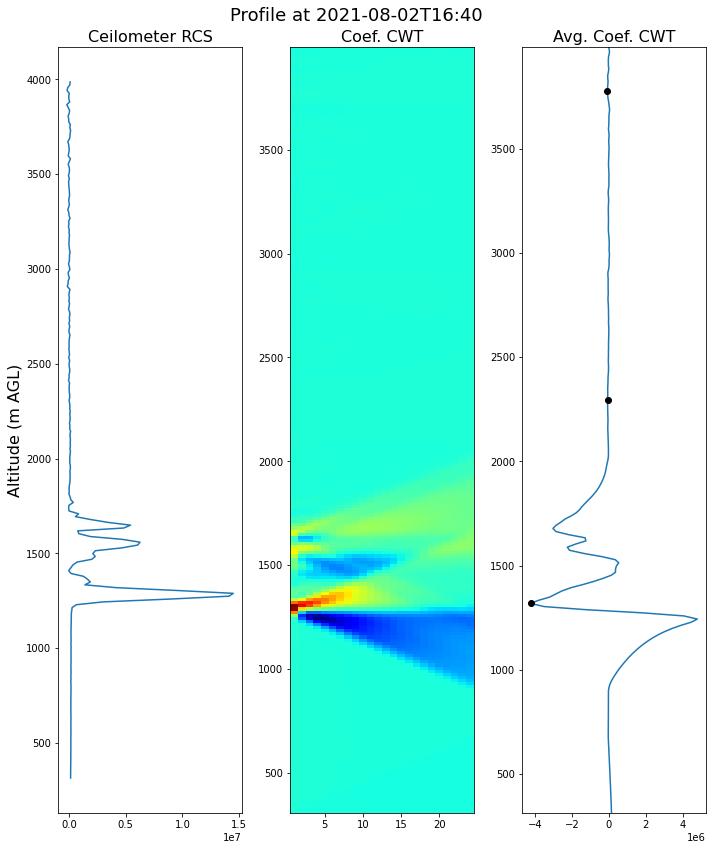

In [11]:
c = np.zeros((profile.values[0, :].shape[0], len(a_vals)))

for a, j in zip(a_vals, np.arange(0, c.shape[1])):
    cwt, f, wavelets = covariance_profile(profile.values[profile_index, :], a, alts)
    c[:, j] = cwt
    
c_avg = np.nanmean(c, axis=1)

peaks, properties = find_peaks(-1*c_avg, **parms)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,12))
ax[0].plot(f, alts)
ax[0].set_ylabel("Altitude (m AGL)", fontsize=16)
ax[0].set_title("Ceilometer RCS", fontsize=16)

ax[1].pcolormesh(a_vals, alts, -1*c, cmap="jet")
ax[1].set_title("Coef. CWT", fontsize=16)

ax[2].plot(c_avg, alts)
ax[2].plot(c_avg[peaks], alts[peaks], "ko")
ax[2].set_ylim(alts[0], alts[-1])
ax[2].set_title("Avg. Coef. CWT", fontsize=16)


plt.suptitle(f"Profile at {np.datetime_as_string(profile.time[profile_index].values, unit='m')}", fontsize=18)
plt.tight_layout()

---
#### Applying to whole profile
---

**Finding Peaks** 

In [12]:
C_avg = coef_avg(profile.values, a_vals)

peaks_index = np.zeros((C_avg.shape[0], 50))
for i in np.arange(0, C_avg.shape[0]):
    peaks, properties = find_peaks(-1*C_avg[i, :], **parms)
    # print(peaks)
    order_test = sorted(((value, index) for index, value in enumerate(properties["prominences"])))
    for j in range(0, len(peaks)):
        peaks_index[i, j] = peaks[order_test[j][1]]

peak_index = np.int64(peaks_index)
print(peak_index)

[[45  0  0 ...  0  0  0]
 [43  0  0 ...  0  0  0]
 [24  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


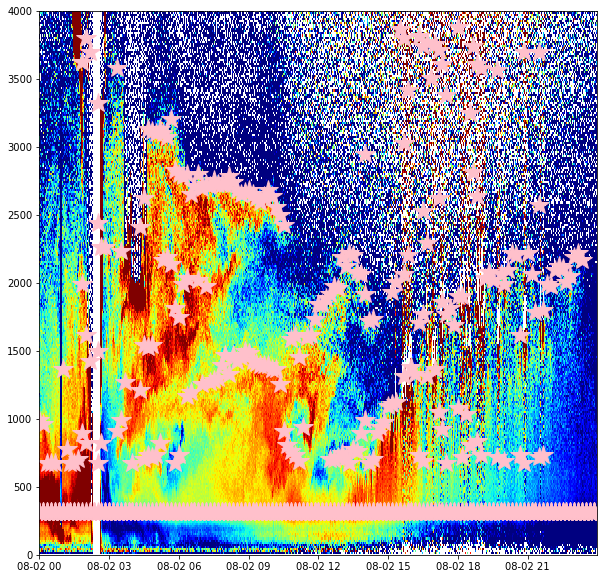

In [13]:
test = Data[keys[0]]["RCS"]

plt.figure(figsize=(10,10))
plt.pcolormesh(test.time, test.range, test.T, cmap='jet', norm=LogNorm(),shading='auto')
plt.clim(vmin=10**5, vmax=10**5.5)
plt.ylim([0,4000])

for i in np.arange(0, 5):
    plt.plot(profile.time, alts[peak_index[:, i]], "*", color="pink", markersize=20)

**Choosing Peaks**

In [14]:
res = np.ceil(np.mean([np.abs(alts[i-1] - alts[i]) for i in np.arange(1, len(alts))] ))

pblh = np.zeros(profile.shape[0])
pblh[0] = peak_index[0,0]

for i in np.arange(1, profile.shape[0]): 
    k = np.abs(pblh[np.nonzero(pblh)[0][-1]] - np.abs(peak_index[i, :]))
    
    m = np.argmin(k)
    
    if i < (50):
        Dy = 300
    else: 
        Dy = 1000
        
    if k[m] < (Dy / res): 
        pblh[i] = peak_index[i, m]

In [15]:
print(peak_index[0, 0])
print(k)
print(m)
print(pblh)

45
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
0
[ 45.  43.  24.  24.  24.   0.   0.  31.  24.  24.  26.  39.  34.   0.
   0.  24.  34.   0.   0.   0.  40.  45.  64.   0.   0.   0.  60.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  57.  59.   0.   0.
  63.   0.  64.  65.  66.  72.  77.  68.  77.  74.  76.  79.  78.  74.
  73.  72.  72.  72.  70.  70.  63.  40.  33.  30.  28.  25.  42.   0.
   0.   0.   0.   0.   0.  26.  26.  27.  29.  27.  24.  31.  30.  39.
  45.  24.  26.  39.  42.  44.  52.  53.  54.   0.  67. 126.  71.  68.
  93.  97.  67.   0.  70.  49.  41.  24.   0.   0.   0.  27.  48.  33.
   0.  35.  28.   0.   0.   0.  27.   0.  25.   0.   0.   0.  28.  24.
   0.   0.   0.  27.  28.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


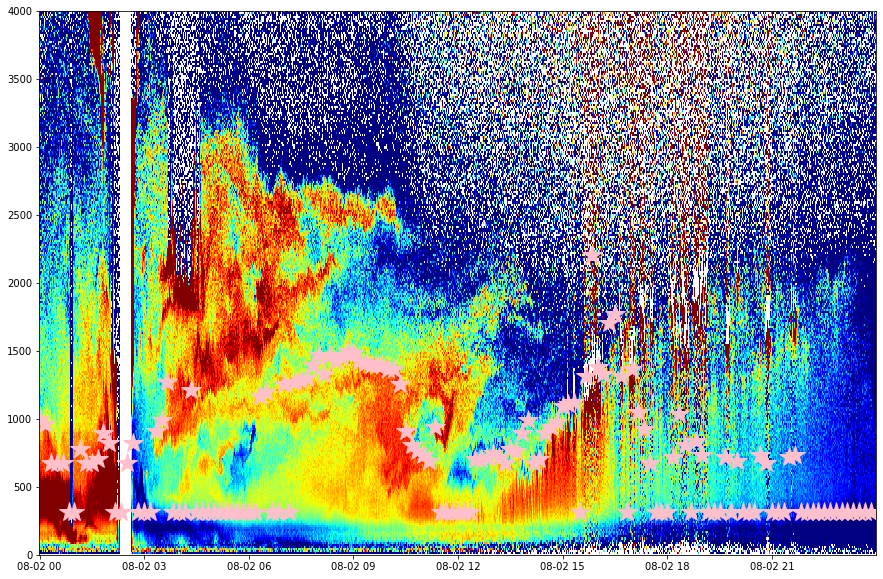

In [16]:
test = Data[keys[0]]["RCS"]

plt.figure(figsize=(15,10))
plt.pcolormesh(test.time, test.range, test.T, cmap='jet', norm=LogNorm(),shading='auto')
plt.clim(vmin=10**5, vmax=10**5.5)
plt.ylim([0,4000])

plt.plot(profile.time, alts[np.int64(pblh)], "*", color="pink", markersize=20)

The values at the bottom are not retrieved pblh. They are just zero indexies of the altitude array. They will be masked as NaN values in the final. 